# Neural Collapse and Data Distillatioin

This notebook implements data distillation with neural collapse by only one step. The main papers considered here are https://github.com/SsnL/dataset-distillation and https://github.com/tding1/Neural-Collapse. The neural network is firstly trained to its terminal phase and then distills synthesized data as introduced. Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/
    !git clone https://github.com/SzYang721/DD-NC.git
    %cd /content/drive/My Drive/DD-NC
    !git config --global user.email "yangsongze2008@gmail.com"
    !git config --global user.name "SzYang721"
    sys.path.append('/content/drive/My Drive/DD-NC/')
    sys.path.append('/content/drive/My Drive/model_weights/')
    print("Environment setup complete.")

In [2]:
# !pip install --upgrade wandb
import wandb
wandb.login()

wandb: Currently logged in as: yangsongze2008 (data-distillation-with-nc). Use `wandb login --relogin` to force relogin


True

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import pickle
import scipy.linalg as scilin
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torchsummary import summary

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [4]:
import models
from models import resnet_decode
from models.res_adapt import ResNet18_adapt
from utils import *

from train_Encoder import train
from validate_NC import *

from data.datasets import make_dataset
from data.data_loading import get_cifar10_data_loaders
from arg_loader import *

# Control Board

In [5]:
TUNE_ENCODER  = False
TRAIN_ENCODER = False
EVALUATE_ENCODER = False

LOAD_ENCODER_STATE_DICT = True
ENCODER_STATE_DICT_NUMBER = 43

FREEZE_ENCODER = True

LOAD_DECODER_STATE_DICT = True
DECODER_STATE_DICT_NUMBER = 79

TUNE_AE_endtoend  = False
TRAIN_AE_endtoend = False
EVALUATE_ENCODER_endtoend = False

LOAD_DECODER_STATE_DICT = True
DECODER_STATE_DICT_NUMBER = 79

# Load Parameters

In [49]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=0
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=0
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
normalize = False
uid="Resnet18-design(high)-SGD-normalize"
force=True

# learning options
epochs = 200
batch_size = 256
loss = 'CrossEntropy'
sample_size = None

# optimization (change for autoencoder)
lr=0.05
patience = 40
history_size=10
optimizer = "SGD"
decay_type = "step"

## Check the best device on machine
check = False

Determine the best device to run on: CUDA, MPS (Apple Silicon GPU), or CPU

In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(gpu_id)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

# device = torch.device("cpu")
# device_name = "CPU"

Using device: cuda:0, NVIDIA TITAN V


In [51]:
args = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience, decay_type = decay_type,
                  device = device)

override this uidResnet18-design(high)-SGD-normalize
cudnn is used


# Load Dataset

In [52]:
trainloader, testloader, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA, normalize = normalize)
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
input_size = height, width, channels
print("The number of class is ", num_classes)
print("Batch size: %d | Input size: %s" % (size_train,input_size))
print("The dataset ranges: (%d, %d)" % (torch.min(images), torch.max(images)))

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
The number of class is  10
Batch size: 256 | Input size: (32, 32, 3)
The dataset ranges: (0, 1)


In [53]:
# trainloader, testloader, traindataset, testdataset = get_cifar10_data_loaders(download=True, batch_size=batch_size)
# images, labels = next(iter(trainloader))
# size_train, channels, height, width = images.shape
# input_size = height, width, channels
# print("The number of class in our training set is ", num_classes)
# print("Batch size: %d | Input size: %s" % (size_train,input_size))
# print("The dataset range from %d to %d" % (torch.min(images), torch.max(images)))

# Load Model

In [54]:
if args.model == "MLP":
    Encoder = models.__dict__[args.model](hidden = args.width, depth = args.depth, fc_bias=args.bias, num_classes=num_classes).to(args.device)
elif args.model == "ResNet18_adapt":
    Encoder = ResNet18_adapt(width = args.width, num_classes=num_classes, fc_bias=args.bias).to(args.device)
else:
    Encoder = models.__dict__[args.model](num_classes=num_classes, fc_bias=args.bias, ETF_fc=args.ETF_fc, fixdim=args.fixdim, SOTA=args.SOTA).to(args.device)

print('# of model parameters: ' + str(count_network_parameters(Encoder)))
print(type(Encoder))

# of model parameters: 11213450
<class 'models.resnet.ResNet'>


In [55]:
summary(Encoder.to("cpu"), input_size=(3, 32, 32), device = "cpu")
Encoder.to(args.device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv

# Create experiments on weights&biases

## Hyperparameter tuning

In [56]:
if TUNE_ENCODER:
    # Set up a sweep configuration
    sweep_configuration = {
        "method": "bayes",
        "name": "sweep",
        "metric": {"goal": "minimize", "name": "losses.avg"},
        "parameters": {
            "batch_size": {"values": [64, 128, 256]},
            "lr": {"max": 0.1, "min": 0.0001},
        },
    }
    # Get sweep ID
    sweep_id = wandb.sweep(sweep_configuration, project="DDNC_hyper")
    def hypertuning_train(config = None, args = args):
        # Initial a new run
        run = wandb.init(project="DDNC_hyper", config = config, settings=wandb.Settings(start_method="thread"))
        print("Initialise finished, starting now...")
        args.lr = wandb.config.lr
        args.batch_size = wandb.config.batch_size
        train(args,Encoder,trainloader)
    # hypertuning_train(config = sweep_configuration, args = args)
    # Start sweep
    wandb.agent(sweep_id, function=hypertuning_train, count=10)

## Model Training

In [57]:
if TRAIN_ENCODER or EVALUATE_ENCODER:
    config = {
        # architecture params
        "model":encoder,
        "bias": bias,
        "ETF_fc":ETF_fc,
        "fixdim":fixdim,
        "SOTA":SOTA,
        
        # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
        "width":width,
        "depth":depth,
        
        # hardware settings
        "gpu_id":gpu_id,
        "seed":seed,
        "use_cudnn":use_cudnn,
        
        # dataset
        "dataset":dataset,
        "data_dir":data_dir,
        "uid":uid,
        "force":force,
        
        # learning options
        "epochs": epochs,
        "batch_size":batch_size,
        "loss": loss,
        "sample_size": sample_size,
        
        # optimization
        "lr":lr,
        "optimizer":optimizer,
        "decay type": decay_type,
        "device" :device
    }
    
    run = wandb.init(
        project="DD&NC",
        notes="Resnet18 with SOTA",
        tags=["Epochs: 200","Resnet18","SGD","cifar10","SOTA"],
        config= config
    )

In [58]:
if TRAIN_ENCODER:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    train(args,Encoder,trainloader)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

## Model Evaluating

In [59]:
if EVALUATE_ENCODER:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    if 'google.colab' in sys.modules:
        load_path = "/content/drive/MyDrive/model_weights/"+args.uid+"/"
    elif socket.gethostname() == "dijkstra":
        load_path = '/data5/model_weights/'+args.uid+"/"
    else:
        load_path = "./model_weights/"+args.uid+"/"
    
    evaluate_NC(args,load_path,Encoder,trainloader,testloader,nearest_neighbor=True)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [60]:
if TRAIN_ENCODER or EVALUATE_ENCODER:
    wandb.finish()

# Validation of Neural Collapse

Neural collapse, emerged in the terminal phase of training(TPT), let us understand the behavior of a special class of neural network, deep classifier neural network. It has widely observed in a number of data set and model structures. Is has mainly 4 fold of meaning:

- **(NC1)** Cross-example within-class variability of last-layer training activations collapses to zero, as the individual activations themselves collapse to their class means. 

- **(NC2)** The class means collapse to the vertices of a simplex equiangular tight frame (ETF). 

- **(NC3)** Up to rescaling, the last-layer classifiers collapse to the class means or in other words, to the simplex ETF (i.e., to a self-dual configuration). 

- **(NC4)** For a given activation, the classifier’s decision collapses to simply choosing whichever class has the closest train class mean (i.e., the nearest class center decision rule).

Let's denote the last linear layer as, which is also known as unconstrained feature model:

$$
h = \phi_\theta(x) \in R^{d \times n}
$$

The output of the neural network as:

$$
\Phi_\Theta(x) = W_Lh+b_L
$$

Denote $N = nk, H = [h_{1,1},..., h_{k,n}] \in R^{d \times N}$, so that the last layer can be written as $R^d \rightarrow R^k$. Also, let's denote the within-class and between-class covariance matrices as $\Sigma_W$ and $\Sigma_B$.

In general, neural collapse can be written in summary as:

$$
\Sigma_W \rightarrow 0, \\
H \rightarrow \bar{H} \rightarrow ETF, W \rightarrow \bar{H}
$$

We can measure the NC in 4 metrics:

$$
NC_1:=\frac{1}{K}trace(\Sigma_W\Sigma_B^{+})\\
NC_2:= ||\frac{WW^T}{||WW^T||_F}-\frac{1}{\sqrt{K-1}} (I_K - \frac{1}{K}1_K1_K^T)||_F\\
NC_3:= ||\frac{W\bar{H}^T}{||W\bar{H}^T||_F}-\frac{1}{\sqrt{K-1}} (I_K - \frac{1}{K}1_K1_K^T)||_F\\
NC_4:=||b+Wh_G||_2
$$

The $NC_4$ follows the simplified rule: $Wh_{k,i}+b = W(h_{k,i} - h_G) + Wh_G +b$, and $Wh_G +b$ should be 0 in the TPT.

## Find the ETF center

Let's introduce the global mean and class mean of the last-layer features ${h_{k,i}}$ as:

$$
h_G = \frac{1}{nK}\sum^{K}_{k=1}\sum^{n}_{i=1}h_{k,i}, \ \bar{h_k} = \frac{1}{n}\sum_{i=1}^{n}h_{k,i}(1\leq k \leq K)
$$

The ETF center of the last layer features, or the centered class-mean matrix,: $\bar{H} = [\bar{h_{1}} - h_G,..., \bar{h_{K}} - h_G]$. 


## Visualization of K-ETF

A (K-Simplex ETF) is a collection of points in $R^K$ specified by the columns of:

$$
M = \sqrt\frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

where $I_K \in R^{K \times K}$ is the identity matrix, and 1K ∈ RK is the all ones vector. In the other words, we also have

$$
M^TM = MM^T =\frac{K}{K − 1}(I_K −\frac{1}{K}1_K1_K^T)
$$

However, the learned features of neural network is often up to some scaling and rotation, thus we consider the general ETF as a collection of points in $R^d$ specified by the columns of $\sqrt\frac{K}{K-1} P (I_K −\frac{1}{K}1_K1_K^T)$, where $P \in R{d \times K} (d \leq K)$ is a orthonormal matrix, i.e., $P^TP = I_K$.

### Further Explaination

The neural collapse shows that as training proceeds, last-layer features $H$ collapse onto their class means ($NC1$), class means converge to the vertices of the simplex ETF ($NC2$), and the linear classifiers $W$ approach their corresponding class means ($NC3$). 

In the collapse stage, the $NC2$ says that the class-means centered at their global means form a Simplex Equiangular Tight Frame - or Simplex ETF. More specifically, the weigths matrix $W^{*T} \in R^{d \times d}$ with $U^TU = I_d$, the normalised matrix $M:=\frac{1}{w^*}UW^{*T}$

$$
M^TM = \frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

Depending on whether to fix the output dimension, we will get shapeful $W \in R^{k \times d}$ and $H \in R^{d \times N}$. The dimension of bias in the last linear layer is always fixed at $b \in R^{k \times N}$. Define $N=nk$ and k is the number of classes and n is the number of images (input data) in each class.

If we fixed the $W$, it is easy to show that the class means will converge to a standard K-ETF.

In [61]:
def k_etf(K=10):
    constant = torch.sqrt(torch.tensor(K/(K-1)))
    ETF = (torch.eye(K)-(1/K)*torch.ones((K, K)))
    return constant*ETF

def k_etf_normalize(etf):
    K = etf.shape[1]
    norm = torch.sqrt((1/K*torch.norm(etf, 'fro')**2))
    return etf/norm

def k_etf_colunm_norm(etf):
    return torch.sqrt(torch.sum(torch.square(etf), axis=0))

In [62]:
print(k_etf(K=10))

print(k_etf_colunm_norm(k_etf_normalize(k_etf(K=10))))

tensor([[ 0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
          0.9487, -0.1054],
        [-0.1054, -

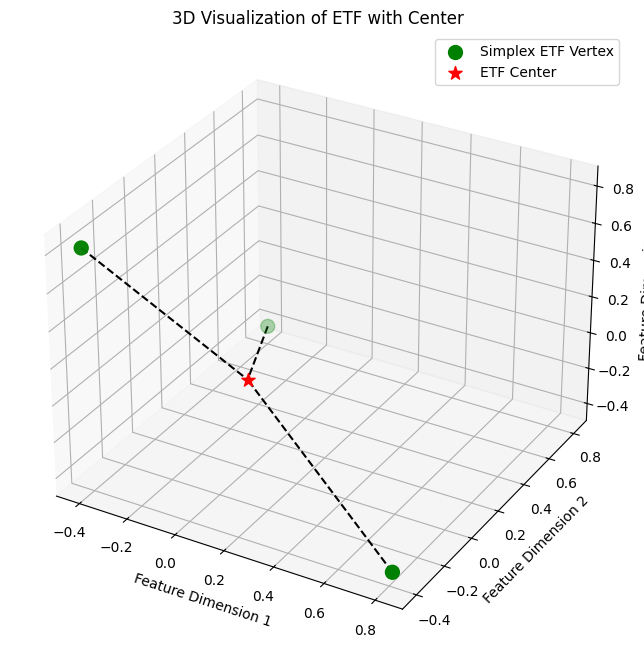

In [63]:
# Step 1: Generate the ETF matrix (as a PyTorch tensor)
simplex_vertices = k_etf(3)

# Step 2: Calculate the ETF center with PyTorch
etf_center = torch.mean(simplex_vertices, dim=0)

# Step 3: Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert PyTorch tensors to numpy arrays for plotting
simplex_vertices_np = simplex_vertices.numpy()
etf_center_np = etf_center.numpy()

# Plotting simplex ETF vertices
ax.scatter(simplex_vertices_np[:, 0], simplex_vertices_np[:, 1], simplex_vertices_np[:, 2], color='green', s=100, marker='o', label='Simplex ETF Vertex')

# Plotting the ETF center
ax.scatter(etf_center_np[0], etf_center_np[1], etf_center_np[2], color='red', s=100, marker='*', label='ETF Center')

# Drawing lines from each vertex to the ETF center
for vertex in simplex_vertices_np:
    ax.plot([vertex[0], etf_center_np[0]], [vertex[1], etf_center_np[1]], [vertex[2], etf_center_np[2]], 'k--')

# Labels and legend
ax.set_xlabel('Feature Dimension 1')
ax.set_ylabel('Feature Dimension 2')
ax.set_zlabel('Feature Dimension 3')
plt.title('3D Visualization of ETF with Center')
ax.legend()

plt.show()

## Analysis of Features

The improved neural network design shows us that we can fix the weight matrix $W$ as standard K-ETF and set the feature dimension $d$ equal to $k$, the number of class. We can plot this ETF and see if it matches.

In [64]:
if 'google.colab' in sys.modules:
    load_path = "/content/drive/MyDrive/model_weights/"+args.uid+"/"
elif socket.gethostname() == "dijkstra":
    load_path = '/data5/model_weights/'+args.uid+"/"
else:
    load_path = "./model_weights/"+args.uid+"/"

Encoder = Encoder.to(device)

fc_features = FCFeatures()
Encoder.fc.register_forward_pre_hook(fc_features)

print('--------------------- Evaluating -------------------------------')

### investigate a specific epochs
i = ENCODER_STATE_DICT_NUMBER
###

map_location=torch.device(args.device)
if LOAD_ENCODER_STATE_DICT:
    Encoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt',map_location=map_location))

Encoder.eval()

for n, p in Encoder.named_parameters():
    if 'fc.weight' in n:
        W = p
    if 'fc.bias' in n:
        b = p
        
W = W.to(device)
b = b.to(device)

print("W is", W)
print("The shape of our weigths in this epochs is ", W.shape)

--------------------- Evaluating -------------------------------
W is Parameter containing:
tensor([[ 0.9487, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054,  0.9487, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054, -0.1054,  0.9487,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1054, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
The shape of our weigths in this epochs is  torch.Size([10, 512])


In [65]:
if LOAD_ENCODER_STATE_DICT:
    mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, Encoder, fc_features, trainloader, isTrain=True)
    mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, Encoder, fc_features, testloader, isTrain=False)
    print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
          (i + 1, train_acc1, train_acc5, test_acc1, test_acc5))
    
    _, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)
    
    print("H is", H)
    print(k_etf_normalize(H))
    print("the colmun norm of unnormalised centered features is ", k_etf_colunm_norm(H))
    print("the colmun norm of normalised centered features is ",k_etf_colunm_norm(k_etf_normalize(H)))

[epoch: 44] | train top1: 99.9960 | train top5: 99.9960 | test top1: 73.4600 | test top5: 96.8800 
H is tensor([[ 8.6171, -1.0997, -0.6872,  ..., -1.0912, -0.5889, -0.9213],
        [-1.0019,  9.2778, -1.2149,  ..., -1.0924, -0.6789, -0.6890],
        [-0.5619, -1.3492,  8.4183,  ..., -1.1260, -1.1119, -1.1401],
        ...,
        [ 0.4589,  0.0693, -0.0757,  ..., -0.1149,  0.3368, -0.1300],
        [ 0.1412, -0.0912, -0.0850,  ...,  0.0576,  0.0701, -0.0988],
        [-0.1172,  0.1422, -0.0653,  ..., -0.0379,  0.0668,  0.0787]],
       device='cuda:0')
tensor([[ 0.8847, -0.1129, -0.0706,  ..., -0.1120, -0.0605, -0.0946],
        [-0.1029,  0.9526, -0.1247,  ..., -0.1122, -0.0697, -0.0707],
        [-0.0577, -0.1385,  0.8643,  ..., -0.1156, -0.1142, -0.1171],
        ...,
        [ 0.0471,  0.0071, -0.0078,  ..., -0.0118,  0.0346, -0.0133],
        [ 0.0145, -0.0094, -0.0087,  ...,  0.0059,  0.0072, -0.0101],
        [-0.0120,  0.0146, -0.0067,  ..., -0.0039,  0.0069,  0.0081]],
    

In [68]:
if LOAD_ENCODER_STATE_DICT:
    _, H_test = compute_W_H_relation(W, mu_c_dict_test, mu_G_test)
    print(H_test)
    print(k_etf_normalize(H_test))
    print("the colmun norm of unnormalised centered features is ", k_etf_colunm_norm(H_test))
    print("the colmun norm of normalised centered features is ",k_etf_colunm_norm(k_etf_normalize(H_test)))

tensor([[ 6.3868, -0.9414, -0.2370,  ..., -0.9315, -0.0348, -0.5838],
        [-0.8674,  7.5768, -1.1442,  ..., -1.0498, -0.4282,  0.2395],
        [-0.0988, -1.2546,  5.0221,  ..., -0.7664, -0.9185, -1.0074],
        ...,
        [ 0.3477,  0.0647, -0.0681,  ..., -0.1002,  0.3126, -0.0808],
        [ 0.1156, -0.0776, -0.0452,  ...,  0.0374,  0.0653, -0.0788],
        [-0.0712,  0.1316, -0.0543,  ..., -0.0145,  0.0657,  0.0746]],
       device='cuda:0')
tensor([[ 0.9051, -0.1334, -0.0336,  ..., -0.1320, -0.0049, -0.0827],
        [-0.1229,  1.0737, -0.1621,  ..., -0.1488, -0.0607,  0.0339],
        [-0.0140, -0.1778,  0.7117,  ..., -0.1086, -0.1302, -0.1428],
        ...,
        [ 0.0493,  0.0092, -0.0097,  ..., -0.0142,  0.0443, -0.0115],
        [ 0.0164, -0.0110, -0.0064,  ...,  0.0053,  0.0093, -0.0112],
        [-0.0101,  0.0186, -0.0077,  ..., -0.0021,  0.0093,  0.0106]],
       device='cuda:0')
the colmun norm of unnormalised centered features is  tensor([7.2645, 8.4761, 5.6964

# Data Distillation by Autoencoder

In [ ]:
# architecture params
decoder='resnet18'
bias=True
ETF_fc=True
fixdim=0
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=0
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
normalize = False
uid="Resnet18-design(high)-SGD-normalize-decoder"
force=True

# learning options
epochs = 80
batch_size = 256
loss = 'MSE'
sample_size = None

# optimization (change for autoencoder)
lr=0.05
patience = 40
history_size=10
optimizer = "SGD"
decay_type = "step"

## Check the best device on machine
check = False

In [71]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(gpu_id)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

# device = torch.device("cpu")
# device_name = "CPU"

Using device: cuda:0, NVIDIA TITAN V


In [72]:
auto_args = train_args(model=decoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience, decay_type = decay_type,
                  device = device)

override this uidResnet18-design(high)-SGD-normalize-decoder
cudnn is used


In [73]:
if auto_args.model == "MLP":
    Decoder = models.__dict__[args.model](hidden = auto_args.width, depth = auto_args.depth, fc_bias=auto_args.bias, num_classes=num_classes).to(auto_args.device)
elif auto_args.model == "ResNet18_adapt":
    Decoder = ResNet18_adapt(width = auto_args.width, num_classes=num_classes, fc_bias=auto_args.bias).to(auto_args.device)
else:
    Decoder = resnet_decode.__dict__[auto_args.model](num_classes=num_classes, fixdim=auto_args.fixdim, SOTA=auto_args.SOTA).to(auto_args.device)

print(type(Decoder))

<class 'models.resnet_decode.ResNet'>


In [75]:
summary(Decoder.to("cpu"), input_size=(512, 1, 1), device = "cpu")
Decoder.to(args.device)
if LOAD_DECODER_STATE_DICT:
    Target_uid = "Resnet18-design(high)-SGD-normalize-decoder-from207"
    if 'google.colab' in sys.modules:
        load_path = "/content/drive/MyDrive/model_weights/"+Target_uid+"/"
    elif socket.gethostname() == "dijkstra":
        load_path = '/data5/model_weights/'+Target_uid+"/"
    else:
        load_path = "./model_weights/"+Target_uid+"/"
    i = DECODER_STATE_DICT_NUMBER
    Decoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt',map_location=map_location))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 1, 1]         262,144
   ConvTranspose2d-2            [-1, 512, 1, 1]       2,359,296
       BatchNorm2d-3            [-1, 512, 1, 1]           1,024
              ReLU-4            [-1, 512, 1, 1]               0
   ConvTranspose2d-5            [-1, 512, 1, 1]       2,359,296
       BatchNorm2d-6            [-1, 512, 1, 1]           1,024
              ReLU-7            [-1, 512, 1, 1]               0
        BasicBlock-8            [-1, 512, 1, 1]               0
   ConvTranspose2d-9            [-1, 512, 1, 1]       2,359,296
      BatchNorm2d-10            [-1, 512, 1, 1]           1,024
             ReLU-11            [-1, 512, 1, 1]               0
  ConvTranspose2d-12            [-1, 256, 2, 2]       1,179,648
      BatchNorm2d-13            [-1, 256, 2, 2]             512
  ConvTranspose2d-14            [-1, 25

In [76]:
# for dname, dparameter in decoder.named_parameters():
#     print(f"{dname}: {dparameter.numel()} parameters")

In [77]:
from models.AE import Autoencoder

In [78]:
autoencoder = Autoencoder(Encoder,Decoder)

In [79]:
if FREEZE_ENCODER:
    autoencoder.freeze_encoder()
autoencoder.unfreeze_decoder()
print('# of model parameters: ' + str(count_network_parameters(autoencoder)))
print(type(autoencoder))

# of model parameters: 11735814
<class 'models.AE.Autoencoder'>


## Train Autoencoder end-to-end

In [87]:
from train_AE_endtoend import AE_train_endtoend

In [88]:
if TUNE_AE_endtoend:
    # Set up a sweep configuration
    sweep_configuration = {
        "method": "bayes",
        "name": "sweep",
        "metric": {"goal": "minimize", "name": "losses.avg"},
        "parameters": {
            "batch_size": {"values": [64, 128, 256, 512]},
            "lr": {"max": 0.5, "min": 0.0005},
        },
    }
    # Get sweep ID
    sweep_id = wandb.sweep(sweep_configuration, project="DDNC_hyper_auto")
    def hypertuning_train_AE(config = None, args = args):
        # Initial a new run
        run = wandb.init(project="DDNC_hyper_auto", config = config, settings=wandb.Settings(start_method="thread"))
        print("Initialise finished, starting now...")
        auto_args.lr = wandb.config.lr
        auto_args.batch_size = wandb.config.batch_size
        AE_train(auto_args,autoencoder,trainloader,visualize=True)
    # hypertuning_train(config = sweep_configuration, args = args)
    # Start sweep
    wandb.agent(sweep_id, function=hypertuning_train_AE, count=10)

In [89]:
if TRAIN_AE_endtoend or EVALUATE_ENCODER_endtoend:
    config = {
        # architecture params
        "model":decoder,
        "bias": bias,
        "ETF_fc":ETF_fc,
        "fixdim":fixdim,
        "SOTA":SOTA,
        
        # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
        "width":width,
        "depth":depth,
        
        # hardware settings
        "gpu_id":gpu_id,
        "seed":seed,
        "use_cudnn":use_cudnn,
        
        # dataset
        "dataset":dataset,
        "data_dir":data_dir,
        "uid":uid,
        "encoder_uid": args.uid,
        "force":force,
        
        # learning options
        "epochs": epochs,
        "batch_size":batch_size,
        "loss": loss,
        "sample_size": sample_size,
        
        # optimization
        "lr":lr,
        "optimizer":optimizer,
        "decay type": decay_type,
        "device" :device
    }
    
    run = wandb.init(
        project="DD&NC",
        notes="Undesigned Autoencoder",
        tags=["Epochs: 200","Resnet18","Adam","cifar10","SOTA"],
        config= config
    )

In [90]:
if TRAIN_AE_endtoend:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

    print(start_time)
    print("optimizer: ", auto_args.optimizer)
    
    AE_train_endtoend(args,auto_args,autoencoder,trainloader,visualize = True)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [91]:
if EVALUATE_ENCODER_endtoend:
    # Start timer
    start_time = time.time()
    print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    if 'google.colab' in sys.modules:
        load_path = "/content/drive/MyDrive/model_weights/"+args.uid+"/"
    elif socket.gethostname() == "dijkstra":
        load_path = '/data5/model_weights/'+args.uid+"/"
    else:
        load_path = "./model_weights/"+args.uid+"/"
    
    evaluate_NC(args,load_path,Encoder,trainloader,testloader,nearest_neighbor=True)
    
    # End timer
    end_time = time.time()
    print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_time_minutes = elapsed_time / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [92]:
if TRAIN_AE_endtoend or EVALUATE_ENCODER_endtoend:
    wandb.finish()

## Generate distilled images

In [95]:
if 'google.colab' in sys.modules:
    load_path = "/content/drive/MyDrive/model_weights/"+auto_args.uid+"/"
elif socket.gethostname() == "dijkstra":
    load_path = '/data5/model_weights/'+auto_args.uid+"/"
else:
    load_path = "./model_weights/"+auto_args.uid+"/"

Decoder = Decoder.to(device)

print('--------------------- Evaluating -------------------------------')

### investigate a specific epochs
i = DECODER_STATE_DICT_NUMBER
###

map_location=torch.device(args.device)
if LOAD_DECODER_STATE_DICT:
    Decoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt',map_location=map_location))

print(H.shape)

with torch.no_grad():
    outputs= Decoder(torch.transpose(H, 0, 1))


Encoder.eval()

for n, p in Encoder.named_parameters():
    if 'fc.weight' in n:
        W = p
    if 'fc.bias' in n:
        b = p
        
W = W.to(device)
b = b.to(device)

print("W is", W)
print("The shape of our weigths in this epochs is ", W.shape)

--------------------- Evaluating -------------------------------
torch.Size([512, 10])
W is Parameter containing:
tensor([[ 0.9487, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054,  0.9487, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054, -0.1054,  0.9487,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1054, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1054, -0.1054, -0.1054,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
The shape of our weigths in this epochs is  torch.Size([10, 512])


In [96]:
def make_prediction(W, b, H):
    # linear_output = W@H + b
    # Compute the linear combination for each data point
    linear_output = torch.matmul(W, H) + b
    
    # Apply softmax activation function for classification
    probabilities = torch.nn.functional.softmax(linear_output, dim=-1)
    
    # Get the predicted class labels (the indices with the highest probabilities)
    predicted_labels = torch.argmax(probabilities, dim=-1)
    
    return predicted_labels.tolist()

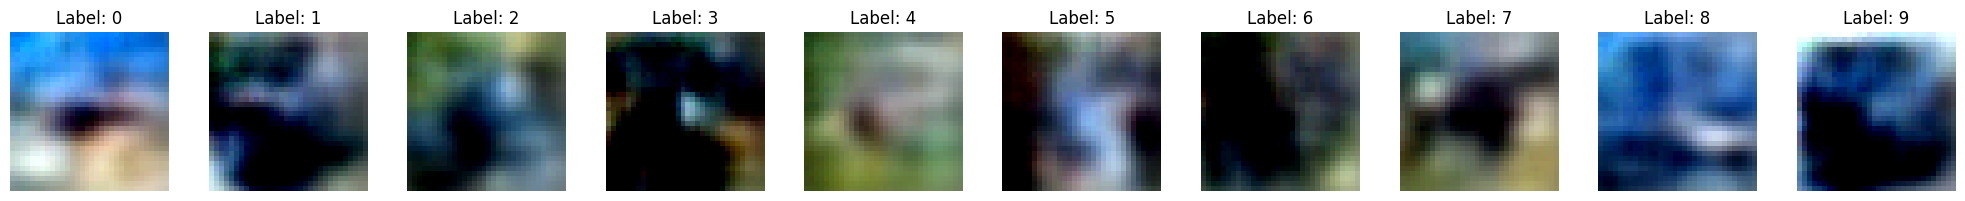

In [97]:
visualize_images(outputs.cpu(), make_prediction(W, b, H))

## To-do list:
## Write a function that find each ETF center label
## Lexing thinks that the 512 dimension might be too large
## 

## Make distilled images

In [100]:
from torch.utils.data import TensorDataset, DataLoader

labels = make_prediction(W, b, H)
labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
print(type(labels))
print(type(outputs))
dataset = TensorDataset(outputs, labels)
distill_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

<class 'torch.Tensor'>
<class 'torch.Tensor'>


## Evaluate model on distilled images

In [109]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=0
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=0
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
normalize = False
uid="Resnet18-design(high)-SGD-normalize-on_distill_data"
force=True

# learning options
epochs = 200
batch_size = 256
loss = 'CrossEntropy'
sample_size = None

# optimization (change for autoencoder)
lr=0.05
patience = 40
history_size=10
optimizer = "SGD"
decay_type = "step"

## Check the best device on machine
check = False

In [110]:
args_test = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience, decay_type = decay_type,
                  device = device)

override this uidResnet18-design(high)-SGD-normalize-on_distill_data
cudnn is used


In [111]:
if args.model == "MLP":
    Test_model = models.__dict__[args.model](hidden = args_test.width, depth = args_test.depth, fc_bias=args_test.bias, num_classes=num_classes).to(args_test.device)
elif args.model == "ResNet18_adapt":
    Test_model = ResNet18_adapt(width = args_test.width, num_classes=num_classes, fc_bias=args_test.bias).to(args_test.device)
else:
    Test_model = models.__dict__[args_test.model](num_classes=num_classes, fc_bias=args_test.bias, ETF_fc=args_test.ETF_fc, fixdim=args_test.fixdim, SOTA=args_test.SOTA).to(args_test.device)

print('# of model parameters: ' + str(count_network_parameters(Test_model)))
print(type(Test_model))

# of model parameters: 11213450
<class 'models.resnet.ResNet'>


In [112]:
# config = {
#     # architecture params
#     "model":encoder,
#     "bias": bias,
#     "ETF_fc":ETF_fc,
#     "fixdim":fixdim,
#     "SOTA":SOTA,
    
#     # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
#     "width":width,
#     "depth":depth,
    
#     # hardware settings
#     "gpu_id":gpu_id,
#     "seed":seed,
#     "use_cudnn":use_cudnn,
    
#     # dataset
#     "dataset":dataset,
#     "data_dir":data_dir,
#     "uid":uid,
#     "force":force,
    
#     # learning options
#     "epochs": epochs,
#     "batch_size":batch_size,
#     "loss": loss,
#     "sample_size": sample_size,
    
#     # optimization
#     "lr":lr,
#     "optimizer":optimizer,
#     "decay type": decay_type,
#     "device" :device
# }

# run = wandb.init(
#     project="Test on distilled dataset",
#     notes="Resnet18",
#     tags=["Epochs: 200","Resnet18","SGD","cifar10","SOTA"],
#     config= config
# )

In [113]:
del sys.modules["wandb"]

KeyError: 'wandb'

In [114]:
# Start timer
start_time = time.time()
print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

train(args_test,Test_model,distill_data)

# End timer
end_time = time.time()
print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

Start time: 2024-05-18 10:46:57
# of model parameters: 11213450
--------------------- Training -------------------------------

Training Epoch: [1 | 200] LR: 0.050000
[epoch: 1] (1/1) | Loss: 3.0089 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [2 | 200] LR: 0.050000
[epoch: 2] (1/1) | Loss: 2.5387 | top1: 10.0000 | top5: 40.0000 

Training Epoch: [3 | 200] LR: 0.050000
[epoch: 3] (1/1) | Loss: 0.9871 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [4 | 200] LR: 0.050000
[epoch: 4] (1/1) | Loss: 0.7314 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [5 | 200] LR: 0.050000
[epoch: 5] (1/1) | Loss: 0.4687 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [6 | 200] LR: 0.050000
[epoch: 6] (1/1) | Loss: 0.3577 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [7 | 200] LR: 0.050000
[epoch: 7] (1/1) | Loss: 0.3065 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [8 | 200] LR: 0.050000
[epoch: 8] (1/1) | Loss: 0.2582 | top1: 10.0000 | top5: 50.0000 

Training Epoch: [9 | 200] LR: 0.

In [115]:
def evaluate_NC(args,load_path,model,trainloader,testloader,nearest_neighbor = False,ontest = False):
    
    args.load_path = load_path

    if args.load_path is None:
        sys.exit('Need to input the path to a pre-trained model!')

    fc_features = FCFeatures()
    model.fc.register_forward_pre_hook(fc_features)
    info_dict = {
            'collapse_metric': [],
            'ETF_metric': [],
            'WH_relation_metric': [],
            'Wh_b_relation_metric': [],
            'W': [],
            'b': [],
            'H': [],
            'mu_G_train': [],
            'mu_G_test': [],
            'train_acc1': [],
            'train_acc5': [],
            'test_acc1': [],
            'test_acc5': []
        }

    print('--------------------- Evaluating -------------------------------')
    for i in range(args.epochs):
        
        
        map_location=torch.device(args.device)
        model.load_state_dict(torch.load(args.load_path + 'epoch_' + str(i + 1).zfill(3) + '.pt', 
                                         map_location=map_location))

        model.eval()

        for n, p in model.named_parameters():
            if 'fc.weight' in n:
                W = p
            if 'fc.bias' in n:
                b = p

        mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, model, fc_features, trainloader, isTrain=True)
        mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, model, fc_features, testloader, isTrain=False)

        Sigma_W = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, trainloader, isTrain=True)
        # Sigma_W_test_norm = compute_Sigma_W(args, model, fc_features, mu_c_dict_train, testloader, isTrain=False)
        Sigma_B = compute_Sigma_B(mu_c_dict_train, mu_G_train)

        collapse_metric = np.trace(Sigma_W @ scilin.pinv(Sigma_B)) / len(mu_c_dict_train)
        ETF_metric = compute_ETF(W)
        WH_relation_metric, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)
        if ontest:
            _, H_test = compute_W_H_relation(W, mu_c_dict_test, mu_G_test)
        if args.bias:
            Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, b)
        else:
            Wh_b_relation_metric = compute_Wh_b_relation(W, mu_G_train, torch.zeros((W.shape[0], )))

        if nearest_neighbor:
            near_train_acc1, near_train_acc5, avg_distance_train = compute_nearest_neighbor(args, model, fc_features, H, trainloader)
            near_test_acc1, near_test_acc5, avg_distance_test = compute_nearest_neighbor(args, model, fc_features, H, testloader)
            if ontest:
                near_test_acc1_ontest, near_test_acc5_ontest, avg_distance_ontest = compute_nearest_neighbor(args, model, fc_features, H_test, testloader)
        
        info_dict['collapse_metric'].append(collapse_metric)
        info_dict['ETF_metric'].append(ETF_metric)
        info_dict['WH_relation_metric'].append(WH_relation_metric)
        info_dict['Wh_b_relation_metric'].append(Wh_b_relation_metric)

        info_dict['W'].append((W.detach().cpu().numpy()))
        if args.bias:
            info_dict['b'].append(b.detach().cpu().numpy())
        info_dict['H'].append(H.detach().cpu().numpy())

        info_dict['mu_G_train'].append(mu_G_train.detach().cpu().numpy())
        info_dict['mu_G_test'].append(mu_G_test.detach().cpu().numpy())

        info_dict['train_acc1'].append(train_acc1)
        info_dict['train_acc5'].append(train_acc5)
        info_dict['test_acc1'].append(test_acc1)
        info_dict['test_acc5'].append(test_acc5)


        print('[epoch: %d] | collapsemetric: %.4f | ETF metric: %.4f | WH metric: %.4f | Wh_b metric: %.4f ' %
                        (i + 1, collapse_metric, ETF_metric, WH_relation_metric, Wh_b_relation_metric))

        print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
                        (i + 1, train_acc1, train_acc5, test_acc1, test_acc5))
        # if not ontest:
        #     print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
        #                     (i + 1, near_train_acc1, near_train_acc5, near_test_acc1, near_test_acc5),"(nearest neighbor accuracy)")
        # else:
        #     print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f | Test ETF test top1: %.4f | Test ETF test top5: %.4f ' %
        #                     (i + 1, near_train_acc1, near_train_acc5, near_test_acc1, near_test_acc5, near_test_acc1_ontest, near_test_acc5_ontest),"(nearest neighbor accuracy)")
        
        if 'wandb' in sys.modules:
            if ontest:
                wandb.log({
                            "train_acc1":train_acc1, 
                            "train_acc5":train_acc5,
                            "test_acc1":test_acc1,
                            "test_acc5":test_acc5,
                            "collapse_metric":collapse_metric, 
                            "ETF_metric":ETF_metric, 
                            "WH_relation_metric":WH_relation_metric,
                            "Wh_b_relation_metric":Wh_b_relation_metric,
                            "nearest neighbor: train_acc1":near_train_acc1, 
                            "nearest neighbor: train_acc5":near_train_acc5,
                            "nearest neighbor: test_acc1":near_test_acc1,
                            "nearest neighbor: test_acc5":near_test_acc5,
                            "nearest neighbor (Test ETF): test_acc1":near_test_acc1_ontest,
                            "nearest neighbor (Test ETF): test_acc5":near_test_acc5_ontest,
                            "nearest neighbor: avg_distance_train":avg_distance_train,
                            "nearest neighbor: avg_distance_test":avg_distance_test,
                            "nearest neighbor: avg_distance_test":avg_distance_ontest,
                            })

            else:
                wandb.log({
                            "train_acc1":train_acc1, 
                            "train_acc5":train_acc5,
                            "test_acc1":test_acc1,
                            "test_acc5":test_acc5,
                            "collapse_metric":collapse_metric, 
                            "ETF_metric":ETF_metric, 
                            "WH_relation_metric":WH_relation_metric,
                            "Wh_b_relation_metric":Wh_b_relation_metric,
                            "nearest neighbor: train_acc1":near_train_acc1, 
                            "nearest neighbor: train_acc5":near_train_acc5,
                            "nearest neighbor: test_acc1":near_test_acc1,
                            "nearest neighbor: test_acc5":near_test_acc5,
                            "nearest neighbor: avg_distance_train":avg_distance_train,
                            "nearest neighbor: avg_distance_test":avg_distance_test
                            })
            
    with open(args.load_path + 'info.pkl', 'wb') as f:
        pickle.dump(info_dict, f)

In [116]:
# Start timer
start_time = time.time()
print("Start time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

if 'google.colab' in sys.modules:
    load_path = "/content/drive/MyDrive/model_weights/"+args_test.uid+"/"
elif socket.gethostname() == "dijkstra":
    load_path = '/data5/model_weights/'+args_test.uid+"/"
else:
    load_path = "./model_weights/"+args_test.uid+"/"

evaluate_NC(args_test,load_path,Test_model,trainloader,testloader)

# End timer
end_time = time.time()
print("End time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

Start time: 2024-05-18 10:49:47
--------------------- Evaluating -------------------------------
[epoch: 1] | collapsemetric: 5.9841 | ETF metric: 0.0000 | WH metric: 1.2186 | Wh_b metric: 446.2831 
[epoch: 1] | train top1: 9.3160 | train top5: 50.0000 | test top1: 9.4500 | test top5: 50.0000 
[epoch: 2] | collapsemetric: 1.5058 | ETF metric: 0.0000 | WH metric: 1.2596 | Wh_b metric: 14527.0186 
[epoch: 2] | train top1: 10.0000 | train top5: 49.8880 | test top1: 10.0000 | test top5: 49.9600 
[epoch: 3] | collapsemetric: 1.5026 | ETF metric: 0.0000 | WH metric: 1.2890 | Wh_b metric: 76887.1406 
[epoch: 3] | train top1: 10.0000 | train top5: 50.0000 | test top1: 10.0000 | test top5: 50.0000 
[epoch: 4] | collapsemetric: 1.5201 | ETF metric: 0.0000 | WH metric: 1.2839 | Wh_b metric: 100226.9375 
[epoch: 4] | train top1: 10.0000 | train top5: 50.0000 | test top1: 10.0000 | test top5: 50.0000 
[epoch: 5] | collapsemetric: 1.5228 | ETF metric: 0.0000 | WH metric: 1.2810 | Wh_b metric: 76556.

## Evaluation by SVM and 1NN

In [8]:
# !pip install scikit-learn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [9]:
# SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(outputs, labels)
svm_predictions = svm_classifier.predict(testlaoder.dataset["images"])
svm_accuracy = accuracy_score(testlaoder.dataset["labels"], svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

# 1-Nearest Neighbor Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(outputs, labels)
knn_predictions = knn_classifier.predict(testlaoder.dataset["images"])
knn_accuracy = accuracy_score(testlaoder.dataset["labels"], knn_predictions)
print(f"1NN Accuracy: {knn_accuracy:.2f}")

NameError: name 'outputs' is not defined